# Graph Visualization

The dataset being worked with is the Amazon Product Co-Purchasing Network, collected on June 1, 2003. It is provided by the Stanford Large Network Dataset Collection ([SNAP](https://snap.stanford.edu/data/)). The data can be briefly described as:

```
Network was collected by crawling Amazon website. It is based on Customers Who Bought This Item Also Bought feature of the Amazon website. If a product i is frequently co-purchased with product j, the graph contains a directed edge from i to j.
```

The data can be found from [here](https://snap.stanford.edu/data/amazon0601.html)

The goal will be to look into how one item (node) influences what else is being purchased along with it. We will measure this for now with which node is most important within the network based on different criteria. 

## Import Packages

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx
import random

## Import Data File

The data file is a simple text file with its structure looking like the following:

<div>
<img src="https://github.com/hellojohncruz/DATA-620/blob/main/Graph%20Visualization/nodes.png?raw=true" width="500"/>
</div>

Reading the file at each line, we will ignore any header comments and the parse the data as a list of edges. 

In [2]:
with open("Amazon0601.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

edges = []
for line in lines:
    if not line.startswith("#"):  # Ignore comments
        parts = line.strip().split("\t")
        if len(parts) == 2:
            edges.append((int(parts[0]), int(parts[1])))

We can now see out list stored with tuples that show a **FromNodeId** and a **ToNodeId** pairing

In [3]:
edges[:5]

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

Lastly, the list will be converted into a pandas DataFrame

In [4]:
df_graph = pd.DataFrame(edges, columns=["from_node", "to_node"])
df_graph.head()

,from_node,to_node
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


## Data Wrangling 

There is no additional data cleaning required. 

## Exploratory Data Analysis

### Number of Node Pairings

We can see our dataset contains almost 3.4 million node pairings. 

In [5]:
pd.options.display.float_format = '{:.0f}'.format
df_graph.count()

from_node    3387388
to_node      3387388
dtype: int64

### Number of Unique IDs

What we can see from this is that we have over 402,000 unique IDs that end up being co-purchased with over 403,000 unique IDs. This makes sense where a customer could buy something that does not mean has a equal relationship of purchasing it in the opposite direction.

In [6]:
df_graph.nunique()

from_node    402439
to_node      403312
dtype: int64

In [7]:
pd.reset_option('display.float_format')

### Number of Edges from a Node

When we collectively count how many edges connect from a node, we can see that a node can have up to ten edges. As we look at the total number of nodes with these types of edge relationships, we vastly see that a majority of nodes have at most ten connections compared to other counts. However, this is a flawed mesaurement as we know that a node has **AT LEAST** ten edges going from itself to another node. This does not count how many come towards it which is then the degree of a node. 

In [8]:
pairs_df = df_graph.groupby('from_node')['to_node'].agg('count').sort_values(ascending=False).reset_index().rename(columns = {'to_node':'number_of_connections'}).groupby('number_of_connections').agg('count').reset_index(drop=False).rename(columns = {'from_node':'total_nodes'})
pairs_df

,number_of_connections,total_nodes
0,1,12121
1,2,15925
2,3,16275
3,4,15475
4,5,14135
5,6,12827
6,7,11906
7,8,11370
8,9,13297
9,10,279108


<Axes: xlabel='number_of_connections', ylabel='total_nodes'>

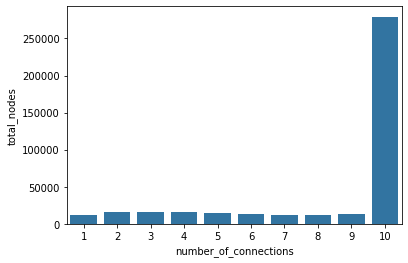

In [9]:
sns.barplot(data = pairs_df, x = 'number_of_connections', y = 'total_nodes')

## Creating our NetworkX Graph

In [10]:
df_graph_sorted = df_graph.sort_values('from_node')
df_graph_filtered = df_graph_sorted[:1000]

In [11]:
G = nx.from_pandas_edgelist(df_graph_filtered, "from_node", "to_node")

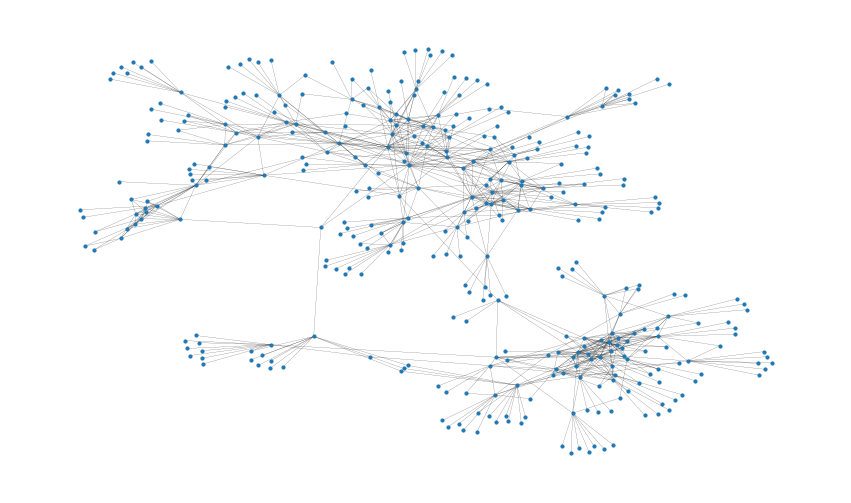

In [12]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}

nx.draw_networkx(G, pos=nx.spring_layout(G, seed=123), ax=ax, **plot_options)

## Network Measurements

### Node with the Highest Diameter

The [diameter](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html) is computed by finding the eccentricity of each node (the maximum distance from that node to any other node in the graph), and then taking the maximum eccentricity value across all nodes. 

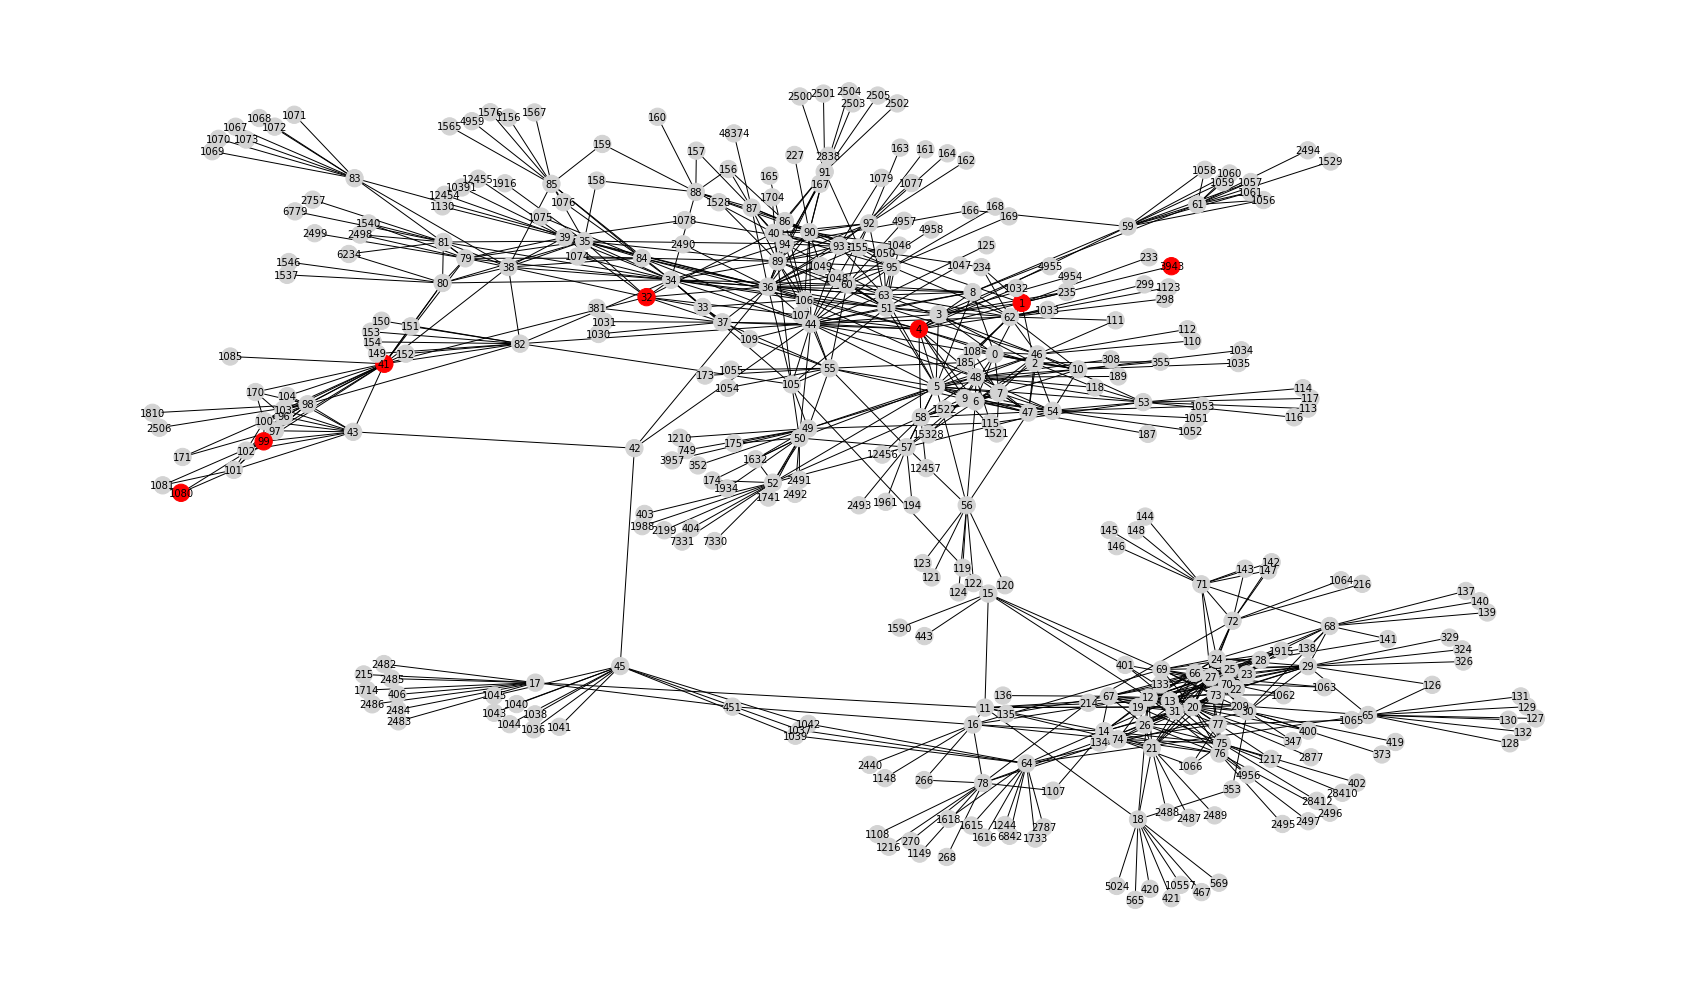

Graph Diameter: 9
Nodes on a Diameter Path: [3943, 1, 4, 32, 41, 99, 1080]


In [27]:
pos = nx.spring_layout(G, seed=123)  

diameter = nx.diameter(G)
periphery = nx.periphery(G)

shortest_path = nx.shortest_path(G, source=periphery[0], target=periphery[-1])
shortest_path_edges = list(zip(shortest_path, shortest_path[1:]))

node_colors = ['red' if node in shortest_path else 'lightgray' for node in G.nodes]
edge_colors = ['yellow' if edge in shortest_path_edges or (edge[1], edge[0]) in shortest_path_edges else 'lightgray' for edge in G.edges]

fig, ax = plt.subplots(figsize=(30, 18))
ax.axis("off")

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=300, font_size=10)

plt.show()

print(f"Graph Diameter: {diameter}")
print(f"Nodes on a Diameter Path: {shortest_path}")

### Node with the Highest Centrality
Centrality measures identify the most important nodes in a graph based on different criterias. Common centrality measures can include degree and betweeness centrality

### Degree Centrality 

This [measure](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality) is calculated as the number of edges (connections) a node has. In this undirected graph, this is just the count of its neighbors. We can see that node 44 has the highest degree centrality with 28 edges connected to it, 

In [14]:
top_degree_centrality = max(nx.degree_centrality(G), key=nx.degree_centrality(G).get)
print(f"Highest Degree Dentrality: {top_degree_centrality}")
print("Number of Edges:", G.degree(44))

Highest Degree Dentrality: 44
Number of Edges: 28


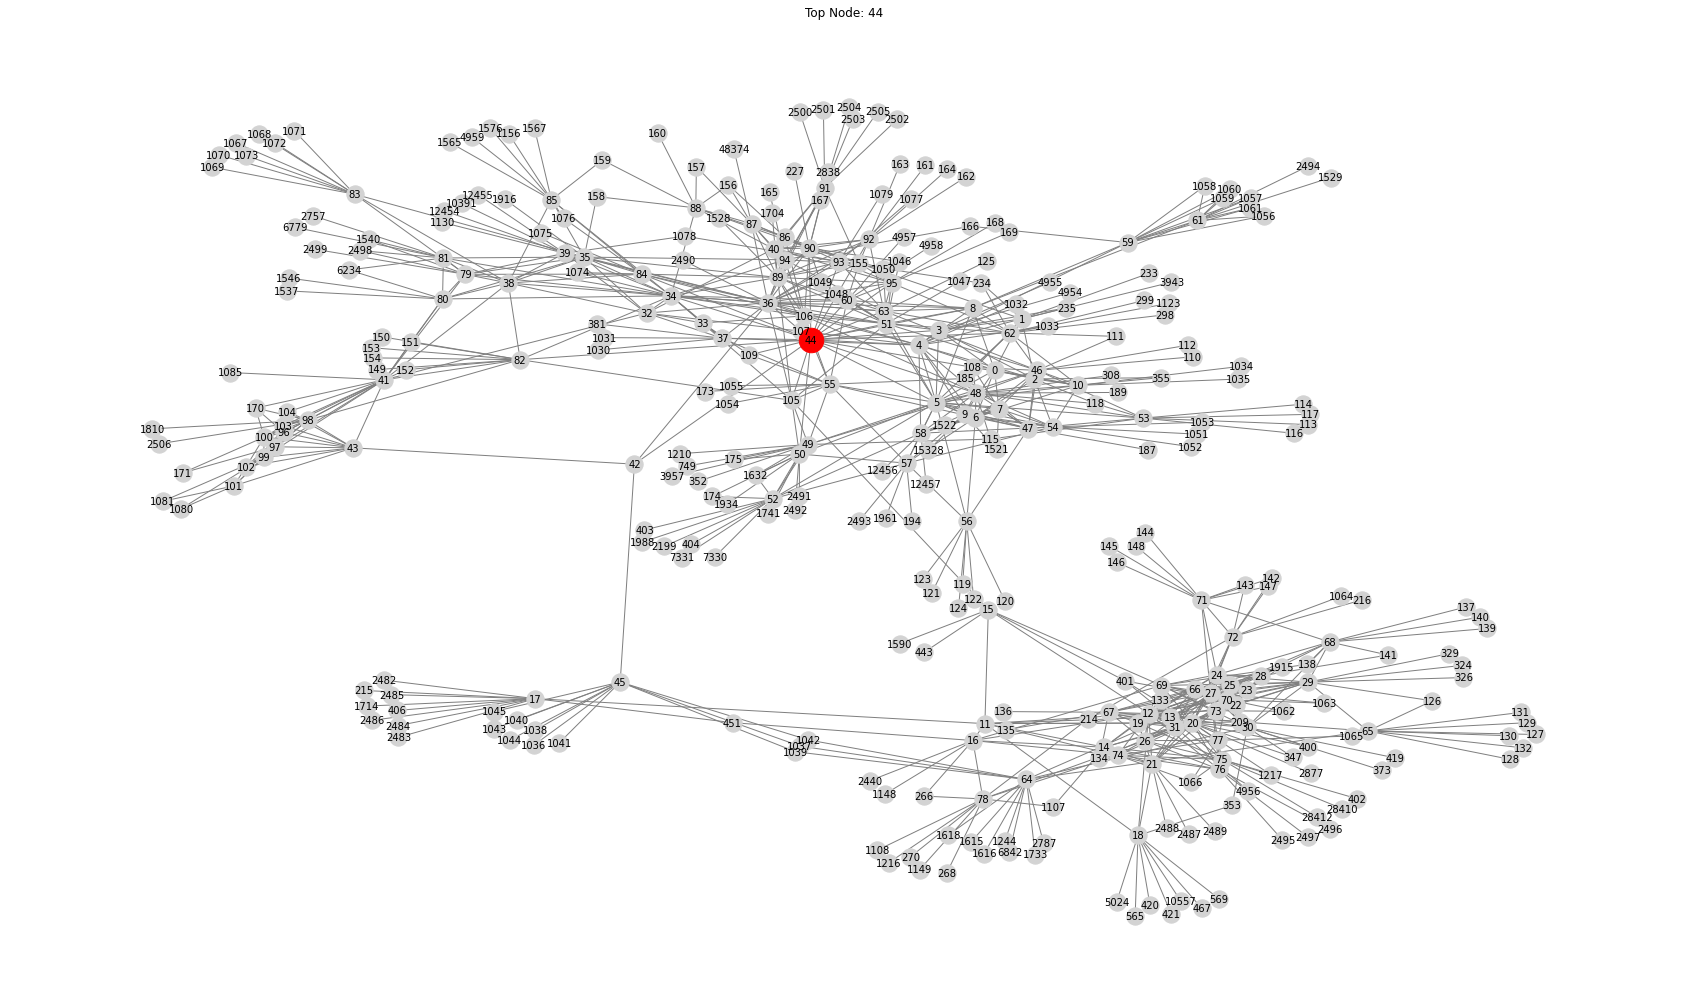

In [15]:
pos = nx.spring_layout(G, seed=123)  

fig, ax = plt.subplots(figsize=(30, 18))
ax.axis("off")

nx.draw(G, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=300, font_size=10)

nx.draw_networkx_nodes(G, pos, nodelist=[top_degree_centrality], node_color="red", node_size=600)

plt.title(f"Top Node: {top_degree_centrality}")
plt.show()

### Betweenness Centrality

This [measures](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality) how often a node appears on the shortest paths between other nodes. A node with high betweenness centrality acts as a bridge between different parts of the network. In our network we find that node 105 has the highest betweeness centrality. We can also see that based on its weights, **node 105 = 0.418** and our previously highest **node 44 = 0.182**. However, before showing the results we will see what node 105 degree looks like. 

In [16]:
print("Number of Edges:", G.degree(105))

Number of Edges: 10


In [17]:
top_betweeness_centrality = max(nx.betweenness_centrality(G), key=nx.betweenness_centrality(G).get)
print(f"Highest Betweenness Centrality: {top_betweeness_centrality}")

Highest Betweenness Centrality: 105


In [18]:
sorted_betweenness = sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)

for node, centrality in sorted_betweenness[:10]:
    print(f"Node {node}: {centrality}")

Node 105: 0.41838468870196843
Node 15: 0.40165234467383626
Node 12: 0.21980218073573138
Node 44: 0.18244389593005708
Node 34: 0.13022138372243222
Node 36: 0.12494105378129233
Node 11: 0.10559388177951297
Node 5: 0.10095663933077788
Node 42: 0.08197238119483063
Node 69: 0.08132638404514923


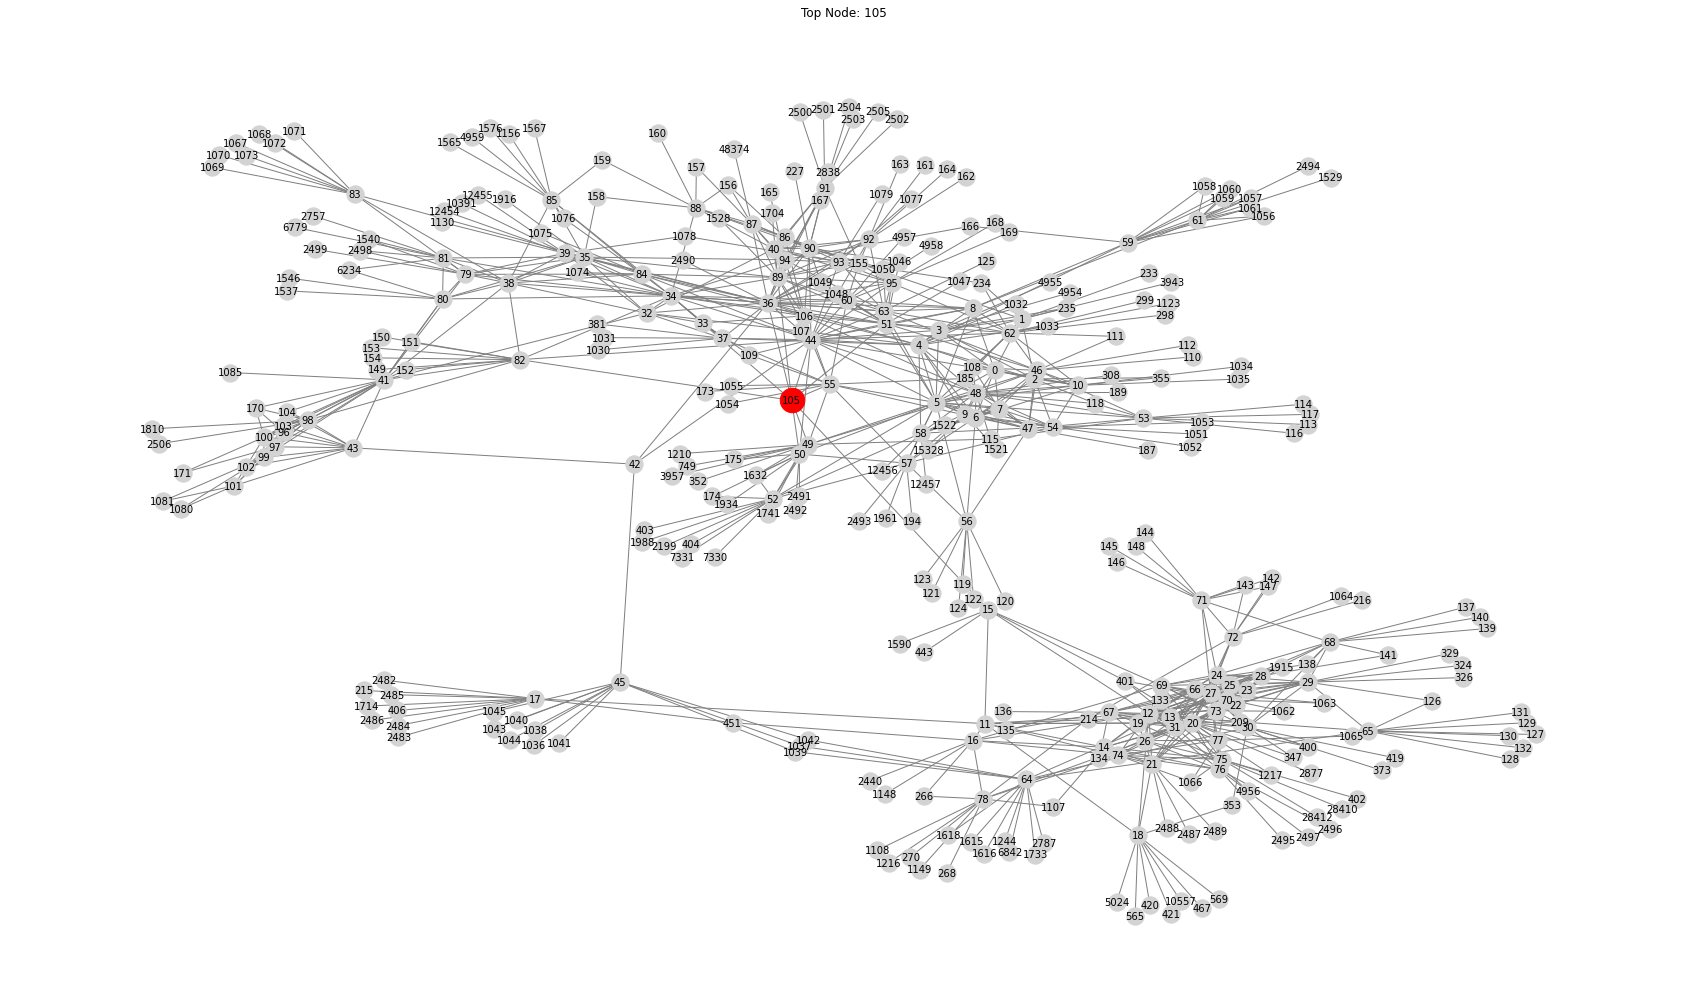

In [19]:
pos = nx.spring_layout(G, seed=123)

fig, ax = plt.subplots(figsize=(30, 18))
ax.axis("off")

nx.draw(G, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=300, font_size=10)

nx.draw_networkx_nodes(G, pos, nodelist=[top_betweeness_centrality], node_color="red", node_size=600)

plt.title(f"Top Node: {top_betweeness_centrality}")
plt.show()

## Conclusion

We found that depending on the type of centrality we use, the most important node can vary within the same network. For future work, I want to be able to parse and include the metadata avaliable that would allow us to view what these node numbers represent exactly. The data source on Stanfords website includes this [here](https://snap.stanford.edu/data/amazon-meta.html). A sample outlook of this data looks as follows:

<div>
<img src="https://github.com/hellojohncruz/DATA-620/blob/main/Graph%20Visualization/metadata.png?raw=true" width="500"/>
</div>